# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 04.11.2022

Мягкий дедлайн: 23:59MSK 16.11.2022

Жесткий дедлайн: 23:59MSK 23.11.2022

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей

In [1]:
# !pip install --upgrade scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [4]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

In [17]:
def plot_curves(y_true, y_pred, clf_name, plot=True):
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    if plot:
        ax[0].plot(recall, precision)
        ax[0].set_title(f"PRC for {clf_name}")
        ax[0].set_xlabel('Recall')
        ax[0].set_ylabel('Precision')
        ax[0].set_ylim(0, 1.1)

    auc_prc = auc(recall, precision)
    print('AUC-PR: %.5f' % auc_prc)

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    print('AUC-ROC: %.5f' % auc_roc)

    if plot:
        ax[1].plot(fpr, tpr)
        ax[1].set_title(f"ROC for {clf_name}")
        ax[1].set_ylim(0, 1.1)
        ax[1].set_xlabel('FPR')
        ax[1].set_ylabel('TPR')
        plt.tight_layout()
        plt.show()
    return auc_roc, auc_prc

AUC-PR: 0.63340
AUC-ROC: 0.50394


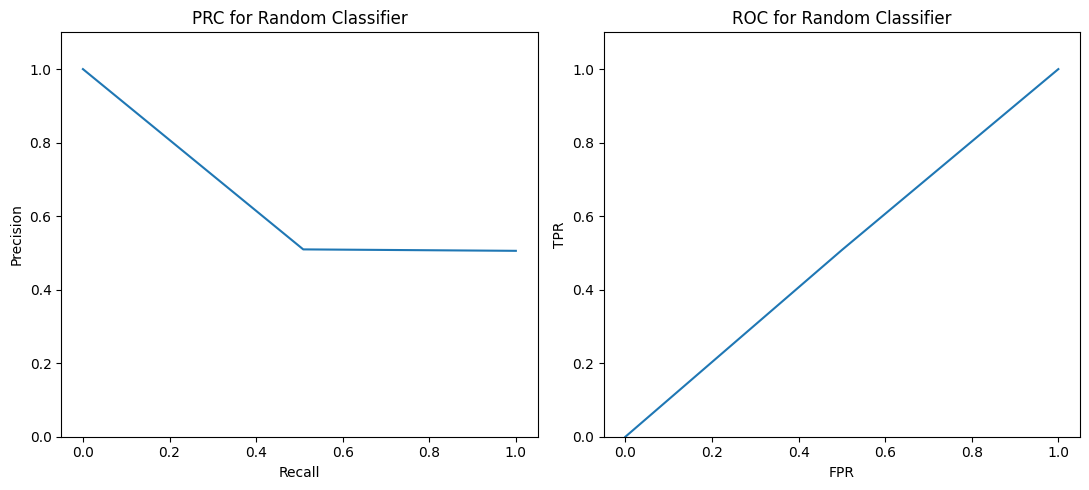

In [18]:
auc_roc, auc_prc = plot_curves(y_test, y_random, 'Random Classifier')

In [19]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc_prc,
    auc_roc,
    None
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

In [20]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


def auc_prc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)


auc_prc_scorer = make_scorer(auc_prc, greater_is_better=True)

In [21]:
parameters = {'C': np.geomspace(0.001, 2, 10)}
clf = SVC(kernel='linear')
gs = GridSearchCV(clf, parameters, cv=7, verbose=1, scoring=auc_prc_scorer)
gs.fit(X_train, y_train)

Fitting 7 folds for each of 10 candidates, totalling 70 fits


GridSearchCV(cv=7, estimator=SVC(kernel='linear'),
             param_grid={'C': array([1.00000000e-03, 2.32691817e-03, 5.41454816e-03, 1.25992105e-02,
       2.93173318e-02, 6.82190321e-02, 1.58740105e-01, 3.69375235e-01,
       8.59505945e-01, 2.00000000e+00])},
             scoring=make_scorer(auc_prc), verbose=1)

In [22]:
best_c = round(gs.best_params_['C'], 4)
best_c

0.8595

In [23]:
clf = SVC(kernel='linear', C=best_c)
clf.fit(X_train, y_train)

SVC(C=0.8595, kernel='linear')

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

AUC-PR: 0.81488
AUC-ROC: 0.84789


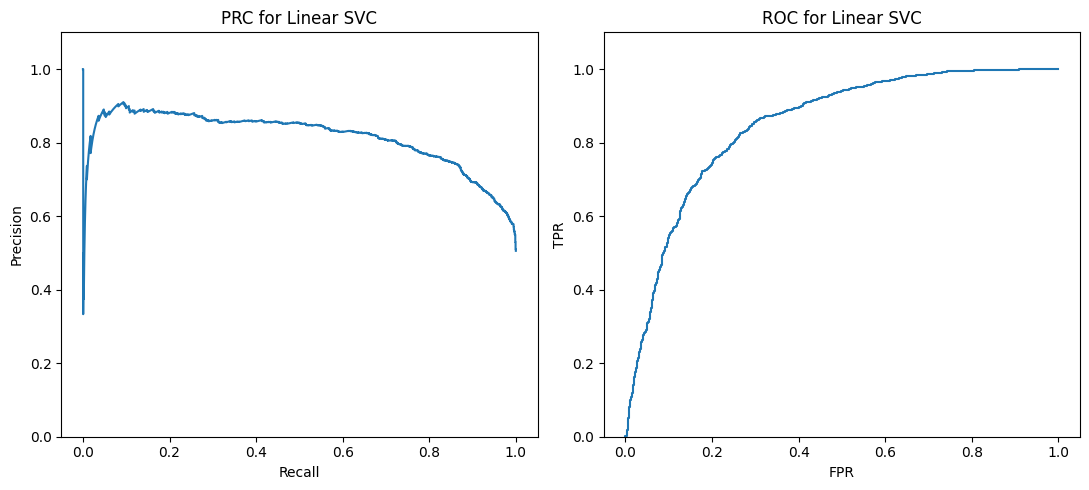

In [24]:
y_pred = clf.decision_function(X_test)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'Linear SVC')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [25]:
df_metrics.loc['Linear SVC'] = [
    auc_prc,
    auc_roc,
    best_c
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear SVC,0.814880,0.847893,0.8595


__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

In [26]:
from sklearn.linear_model import LogisticRegression

parameters = {'C': np.geomspace(0.001, 2, 10)}
clf = LogisticRegression(penalty='l2')
gs = GridSearchCV(clf, parameters, cv=5, verbose=1, scoring=auc_prc_scorer)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-03, 2.32691817e-03, 5.41454816e-03, 1.25992105e-02,
       2.93173318e-02, 6.82190321e-02, 1.58740105e-01, 3.69375235e-01,
       8.59505945e-01, 2.00000000e+00])},
             scoring=make_scorer(auc_prc), verbose=1)

In [27]:
best_c = round(gs.best_params_['C'], 4)
best_c

0.1587

In [28]:
clf = LogisticRegression(penalty='l2', C=best_c)
clf.fit(X_train, y_train)

LogisticRegression(C=0.1587)

AUC-PR: 0.82916
AUC-ROC: 0.84787


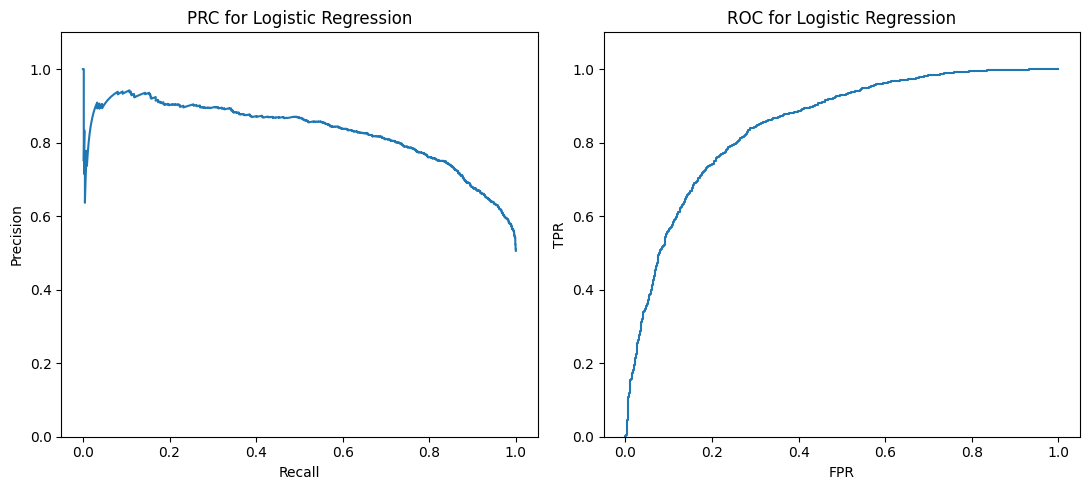

In [29]:
y_pred = clf.predict_proba(X_test)[:, 1]
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'Logistic Regression')

In [30]:
df_metrics.loc['Logistic Regression'] = [
    auc_prc,
    auc_roc,
    best_c
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear SVC,0.814880,0.847893,0.8595
Logistic Regression,0.829159,0.847868,0.1587


__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ: Модели дают почти абсолютно одинаковые метрики AUC, причем пробовал менять C у log reg, но эффект был замечен только на очень маленьких значениях. На остальных - будто почти такая же модель

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [31]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)


# Спер из андана на ПИ
def plot_decision_boundary(model, X, y, sv):
    x1_min, x2_min = X.min(axis=0)
    x1_max, x2_max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(x1_min - 0.5, x1_max + 0.5, 300),
                         np.linspace(x2_min - 0.5, x2_max + 0.5, 300))
    y_pred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    y_pred = y_pred.reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=.4)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    if sv is not None:
        svp = plt.scatter(sv[:, 0], sv[:, 1], c='r', marker='2', s=100)
        plt.legend((svp,), ('support vectors',))
        plt.show()

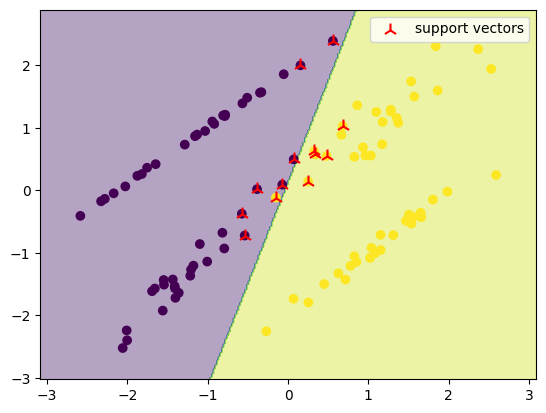

In [32]:
clf = SVC(kernel='linear')
clf.fit(X, y)
plot_decision_boundary(clf, X, y, clf.support_vectors_)


В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

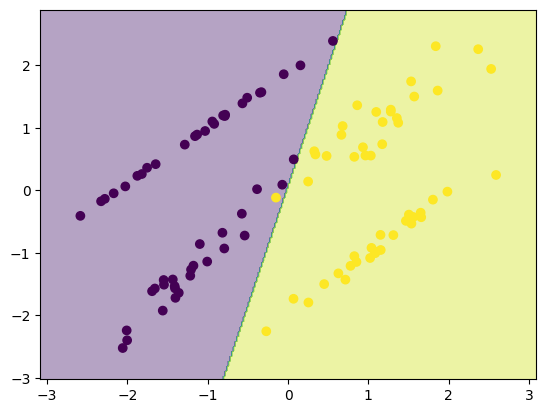

In [33]:
clf = LogisticRegression()
clf.fit(X, y)
plot_decision_boundary(clf, X, y, None)

In [34]:
y_proba = clf.predict_proba(X)[:, 1].reshape(-1, 1)

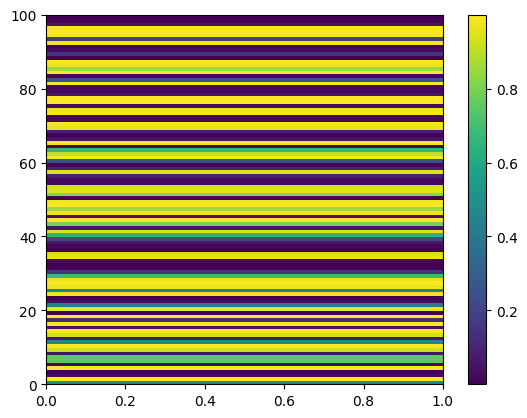

In [35]:
plt.pcolor(y_proba)
plt.colorbar()
plt.show()

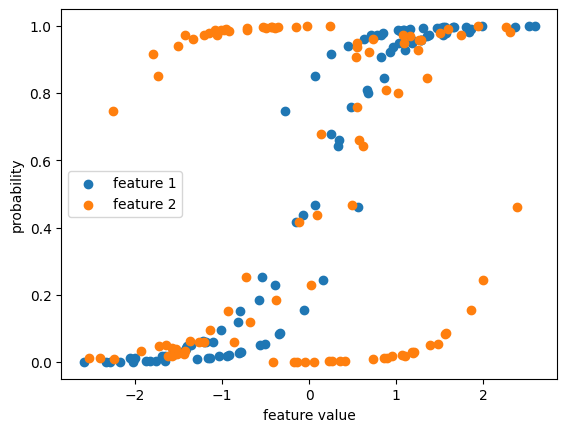

In [36]:
plt.scatter(X[:, 0], y_proba, label='feature 1')
plt.scatter(X[:, 1], y_proba, label='feature 2')
plt.legend()
plt.xlabel('feature value')
plt.ylabel('probability')

plt.show()

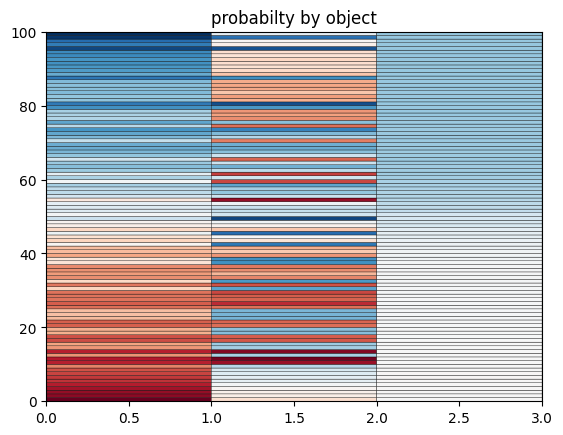

In [37]:

all_in = pd.DataFrame(np.hstack([X[:, 0].reshape(-1, 1), X[:, 1].reshape(-1, 1), y_proba])).sort_values(2)

plt.pcolor(all_in, cmap='RdBu', edgecolors='k')
plt.title('probabilty by object')
plt.show()

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [38]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((r + l) / 2)
        pos = y_test[(preds >= l) & (preds < r) & (y_test == 1)].shape[0]
        total = y_test[(preds >= l) & (preds < r)].shape[0]
        bin_real_ratios.append(1.0 * pos / total)
    plt.figure(figsize=(6, 6))
    plt.plot(bin_middle_points, bin_real_ratios, label='model')
    plt.plot([0, 1], [0, 1], linestyle='dashed', label='ideal')
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

In [39]:
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
lr = LogisticRegression(penalty='l2', C=df_metrics.loc['Logistic Regression', 'reg_const'])
lr.fit(X_train, y_train)
y_proba_lr = lr.predict_proba(X_test)

Logistic Regression


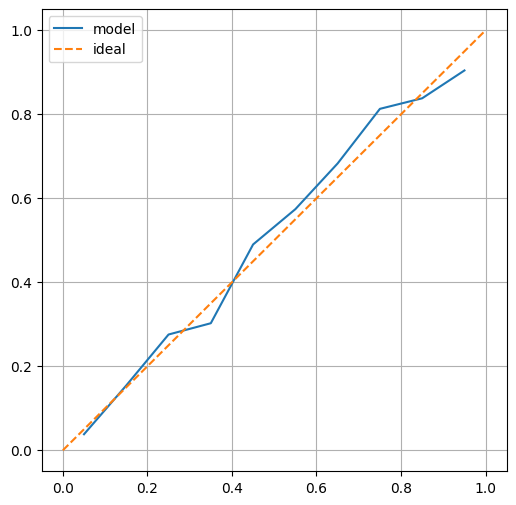

In [41]:
print('Logistic Regression')
plot_calibration_curve(y_test, y_proba_lr[:, 1])

In [42]:
svc = SVC(kernel='linear', C=df_metrics.loc['Linear SVC', 'reg_const'])
svc.fit(X_train, y_train)
y_des = svc.decision_function(X_test)
y_proba_svc = 1 / (1 + np.exp(-y_des))

SVC


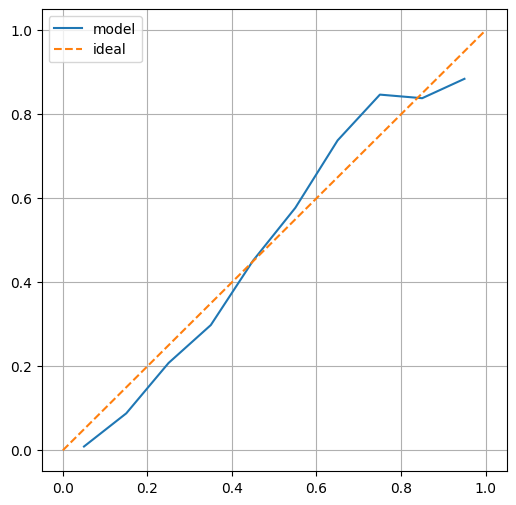

In [43]:
print('SVC')
plot_calibration_curve(y_test, y_proba_svc)

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

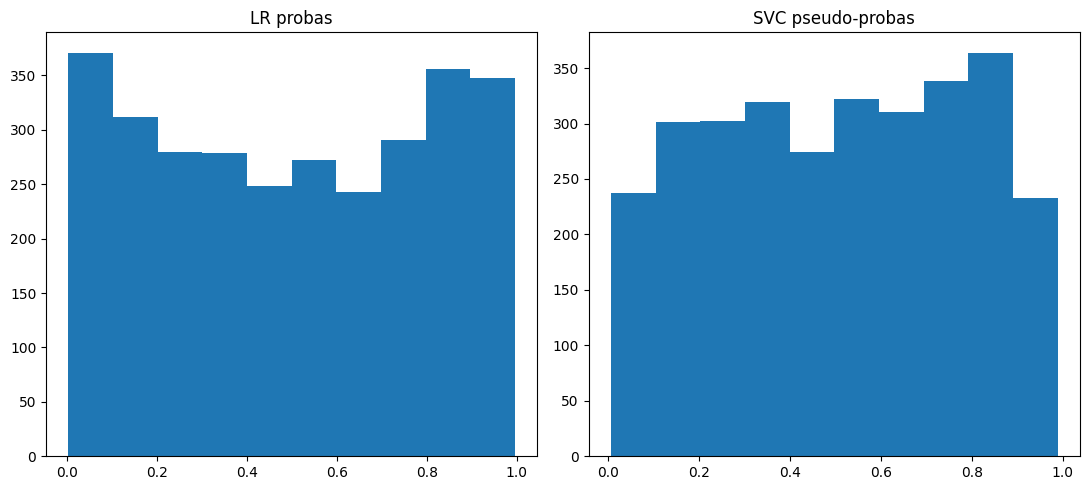

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
ax[0].hist(y_proba_lr[:, 1])
ax[1].hist(y_proba_svc)
ax[0].set_title(f"LR probas")
ax[1].set_title(f"SVC pseudo-probas")

plt.tight_layout()


Чем они различаются? Чем вы можете объяснить это?

Ответ: У LR просадка по центру, у SCV - по краям. Скорее всего потому что svc и занимается максимизацией отступа, а LR пытается угадать честные вероятности и распределение похоже на реально разбросанные данные

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

Calibrated SVC


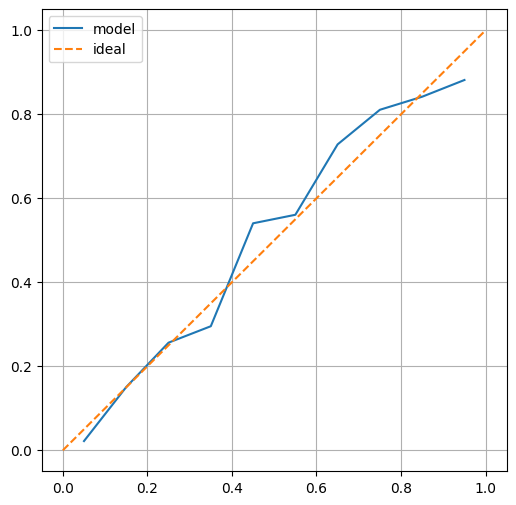

In [45]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_svc = CalibratedClassifierCV(base_estimator=svc, cv='prefit')
calibrated_svc.fit(X_train, y_train)

y_proba_svc = calibrated_svc.predict_proba(X_test)

print('Calibrated SVC')
plot_calibration_curve(y_test, y_proba_svc[:, 1])

Тяжело сказать стало ли лучше (можно конечно площадь вырезанную графиками посчитать при желании). Но визуально стало не сильно лучше

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [46]:
#your code here

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [66]:
# !wget https: // archive.ics.uci.edu / ml / machine-learning-databases / adult / adult.data

In [67]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [68]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [69]:
y = df['income']
X = df.loc[:, df.columns != 'income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=777, stratify=y)
X_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
23937,49,Self-emp-not-inc,171540,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,60,United-States
7776,27,Private,109997,HS-grad,9,Divorced,Other-service,Not-in-family,White,Female,0,0,40,United-States
9151,20,Private,91939,HS-grad,9,Never-married,Adm-clerical,Not-in-family,Black,Female,0,1721,30,United-States
13773,36,Private,163290,Some-college,10,Divorced,Sales,Unmarried,White,Female,0,0,40,United-States
3082,74,Self-emp-inc,162340,Some-college,10,Widowed,Exec-managerial,Unmarried,White,Male,0,0,40,United-States


In [70]:
X_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [71]:
numeric_features = X_train.select_dtypes(include=np.number).columns
print('Numeric:', X_train.columns)
categorical_features = X_train.columns[~X_train.columns.isin(numeric_features)]
print('Categorical:', categorical_features)

Numeric: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Categorical: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')


In [72]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

categorical_transformer = Pipeline(steps=[
    ('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features),
    ])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(max_iter=500))])

In [73]:
%%time
model.fit(X_train, y_train)

CPU times: total: 62.5 ms
Wall time: 104 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('oe',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=500))])

In [74]:
y_pred = model.predict(X_test)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'Logistic Regression ordinal', False)
df_metrics.loc['Logistic Regression ordinal'] = [
    auc_prc,
    auc_roc,
    None
]
df_metrics

AUC-PR: 0.64888
AUC-ROC: 0.69258


,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear SVC,0.814880,0.847893,0.8595
Logistic Regression,0.829159,0.847868,0.1587
Logistic Regression ordinal,0.648882,0.692581,NaN
Logistic Regression OHE,0.716684,0.769507,NaN
Logistic Regression mean target,0.709297,0.761211,NaN
Logistic Regression mean target noisy,0.697242,0.748106,NaN


__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__: Кажется, что AUC-PR можно выбрать когда нам важен класс +1 (как здесь например).
ROC-AUC никак не обращает внимания на положительный класс, в свою очередь у PR есть precision, который показывает сколько действительно положительных объектов из предсказанных моделью.

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [75]:
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features),
    ])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(max_iter=500))])

In [76]:
%%time
model.fit(X_train, y_train)

CPU times: total: 172 ms
Wall time: 175 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=500))])

In [77]:
y_pred = model.predict(X_test)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'Logistic Regression OHE', False)
df_metrics.loc['Logistic Regression OHE'] = [
    auc_prc,
    auc_roc,
    None
]
df_metrics

AUC-PR: 0.71668
AUC-ROC: 0.76951


,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear SVC,0.814880,0.847893,0.8595
Logistic Regression,0.829159,0.847868,0.1587
Logistic Regression ordinal,0.648882,0.692581,NaN
Logistic Regression OHE,0.716684,0.769507,NaN
Logistic Regression mean target,0.709297,0.761211,NaN
Logistic Regression mean target noisy,0.697242,0.748106,NaN


Качество весьма неплохо подросло, но упала скорость

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [78]:
def get_mean_targets(X, y, categorical_names):
    mean_targets = dict()

    for col in categorical_names:
        all_possible = np.unique(X[col])
        mean_targets[col] = dict()

        for value in all_possible:
            mean_target = np.sum((X[col] == value) * (y == 1)) / np.sum(X[col] == value)
            mean_targets[col][value] = mean_target
        mean_targets[col]['mean'] = np.mean(list(mean_targets[
                                                     col].values()))  # Для пропущенных значений будем писать просто среднее счетчиков этой категории
    return mean_targets


def mean_target_encoding(X, mean_targets, categorical_names):
    X_copy = X.copy(deep=True)

    for col in categorical_names:
        all_possible = np.unique(X[col])
        for value in all_possible:
            if mean_targets[col].get(value):
                X_copy.loc[X[col] == value, col] = mean_targets[col].get(value)
            else:
                X_copy.loc[X[col] == value, col] = mean_targets[col].get('mean')

    return X_copy

In [79]:
all_features = [*numeric_features, *categorical_features]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, all_features),
    ])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(max_iter=500))])

In [80]:
%%time
mean_targets = get_mean_targets(X_train, y_train, categorical_features)
X_train_mean = mean_target_encoding(X_train, mean_targets, categorical_features)
X_test_mean = mean_target_encoding(X_test, mean_targets, categorical_features)
model.fit(X_train_mean, y_train)

CPU times: total: 438 ms
Wall time: 434 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', LogisticRegression(max_iter=500))])

In [81]:
y_pred = model.predict(X_test_mean)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'Logistic Regression mean target', False)
df_metrics.loc['Logistic Regression mean target'] = [
    auc_prc,
    auc_roc,
    None
]
df_metrics

AUC-PR: 0.70930
AUC-ROC: 0.76121


,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear SVC,0.814880,0.847893,0.8595
Logistic Regression,0.829159,0.847868,0.1587
Logistic Regression ordinal,0.648882,0.692581,NaN
Logistic Regression OHE,0.716684,0.769507,NaN
Logistic Regression mean target,0.709297,0.761211,NaN
Logistic Regression mean target noisy,0.697242,0.748106,NaN


Видимо из-за неэффективной реализации время сильно выросло. Качество чуть хуже чем у ohe. Была бы эффективная реализация, думаю обогнала бы ohe.

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [82]:
def add_noise(mean_targets, deviation):
    np.random.seed(4244)
    cop = mean_targets.copy()
    for col_name, value in mean_targets.items():
        for k, v in value.items():
            cop[col_name][k] = v + np.random.normal(0, deviation)
    return cop

In [83]:
%%time
mean_targets = get_mean_targets(X_train, y_train, categorical_features)
mean_targets_noisy = add_noise(mean_targets, 0.1)

X_train_mean = mean_target_encoding(X_train, mean_targets_noisy, categorical_features)
X_test_mean = mean_target_encoding(X_test, mean_targets_noisy, categorical_features)
model.fit(X_train_mean, y_train)


CPU times: total: 453 ms
Wall time: 478 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', LogisticRegression(max_iter=500))])

In [84]:
y_pred = model.predict(X_test_mean)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'Logistic Regression mean target noisy', False)
df_metrics.loc['Logistic Regression mean target noisy'] = [
    auc_prc,
    auc_roc,
    None
]
df_metrics

AUC-PR: 0.69724
AUC-ROC: 0.74811


,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear SVC,0.814880,0.847893,0.8595
Logistic Regression,0.829159,0.847868,0.1587
Logistic Regression ordinal,0.648882,0.692581,NaN
Logistic Regression OHE,0.716684,0.769507,NaN
Logistic Regression mean target,0.709297,0.761211,NaN
Logistic Regression mean target noisy,0.697242,0.748106,NaN


Добавили шум из нормального распределения, чутка ухудшив качество. Но хочется верить, что это действительно помогает в борьбе с переобучением

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [85]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [86]:
def get_mean_targets_smooth(X, y, categorical_names, C):
    mean_targets = dict()
    global_mean = y.mean()
    for col in categorical_names:
        all_possible = np.unique(X[col])
        mean_targets[col] = dict()

        for value in all_possible:
            mean_target = (np.sum((X[col] == value) * (y == 1)) + C * global_mean) / (np.sum(X[col] == value) + C)
            mean_targets[col][value] = mean_target
        mean_targets[col]['mean'] = np.mean(list(mean_targets[
                                                     col].values()))  # Для пропущенных значений будем писать просто среднее счетчиков этой категории
    return mean_targets


In [87]:
%%time
mean_targets = get_mean_targets_smooth(X_train, y_train, categorical_features, C=10)
X_train_mean = mean_target_encoding(X_train, mean_targets, categorical_features)
X_test_mean = mean_target_encoding(X_test, mean_targets, categorical_features)
model.fit(X_train_mean, y_train)

CPU times: total: 469 ms
Wall time: 500 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', LogisticRegression(max_iter=500))])

In [88]:
y_pred = model.predict(X_test_mean)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'Logistic Regression mean target smooth', False)
df_metrics.loc['Logistic Regression mean target smooth'] = [
    auc_prc,
    auc_roc,
    None
]
df_metrics

AUC-PR: 0.70947
AUC-ROC: 0.76112


,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear SVC,0.814880,0.847893,0.8595
Logistic Regression,0.829159,0.847868,0.1587
Logistic Regression ordinal,0.648882,0.692581,NaN
Logistic Regression OHE,0.716684,0.769507,NaN
Logistic Regression mean target,0.709297,0.761211,NaN
Logistic Regression mean target noisy,0.697242,0.748106,NaN
Logistic Regression mean target smooth,0.709475,0.761118,NaN


То же самое ище и с шумом

In [89]:
%%time
mean_targets = get_mean_targets_smooth(X_train, y_train, categorical_features, C=10)
mean_targets_noisy = add_noise(mean_targets, 0.1)

X_train_mean = mean_target_encoding(X_train, mean_targets_noisy, categorical_features)
X_test_mean = mean_target_encoding(X_test, mean_targets_noisy, categorical_features)
model.fit(X_train_mean, y_train)

CPU times: total: 422 ms
Wall time: 458 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', LogisticRegression(max_iter=500))])

In [90]:
y_pred = model.predict(X_test_mean)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'Logistic Regression mean target smooth noisy', False)
df_metrics.loc['Logistic Regression mean target smooth noisy'] = [
    auc_prc,
    auc_roc,
    None
]
df_metrics

AUC-PR: 0.69806
AUC-ROC: 0.74876


,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear SVC,0.814880,0.847893,0.8595
Logistic Regression,0.829159,0.847868,0.1587
Logistic Regression ordinal,0.648882,0.692581,NaN
Logistic Regression OHE,0.716684,0.769507,NaN
Logistic Regression mean target,0.709297,0.761211,NaN
Logistic Regression mean target noisy,0.697242,0.748106,NaN
Logistic Regression mean target smooth,0.709475,0.761118,NaN
Logistic Regression mean target smooth noisy,0.698062,0.748755,NaN


Качество в обоих случаях выросло, но на самую капельку

#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [91]:
print(f"Unique age count {X_train['age'].value_counts().shape[0]}")

Unique age count 70


In [92]:
print(f"Unique workclass count {X_train['workclass'].value_counts().shape[0]}")

Unique workclass count 9


In [93]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, all_features),
    ])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(max_iter=500))])

In [94]:
%%time
mean_targets = get_mean_targets_smooth(X_train, y_train, [*categorical_features, 'age'], C=10)
X_train_mean = mean_target_encoding(X_train, mean_targets, [*categorical_features, 'age'])
X_test_mean = mean_target_encoding(X_test, mean_targets, [*categorical_features, 'age'])
model.fit(X_train_mean, y_train)

CPU times: total: 484 ms
Wall time: 508 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', LogisticRegression(max_iter=500))])

In [95]:
y_pred = model.predict(X_test_mean)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'Logistic Regression mean target smooth + age', False)
df_metrics.loc['Logistic Regression mean target smooth + age'] = [
    auc_prc,
    auc_roc,
    None
]
df_metrics

AUC-PR: 0.71532
AUC-ROC: 0.76627


,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear SVC,0.814880,0.847893,0.8595
Logistic Regression,0.829159,0.847868,0.1587
Logistic Regression ordinal,0.648882,0.692581,NaN
Logistic Regression OHE,0.716684,0.769507,NaN
Logistic Regression mean target,0.709297,0.761211,NaN
Logistic Regression mean target noisy,0.697242,0.748106,NaN
Logistic Regression mean target smooth,0.709475,0.761118,NaN
Logistic Regression mean target smooth noisy,0.698062,0.748755,NaN
Logistic Regression mean target smooth + age,0.715316,0.766269,NaN


In [96]:
%%time
mean_targets = get_mean_targets_smooth(X_train, y_train, [*categorical_features, 'workclass'], C=10)
X_train_mean = mean_target_encoding(X_train, mean_targets, [*categorical_features, 'workclass'])
X_test_mean = mean_target_encoding(X_test, mean_targets, [*categorical_features, 'workclass'])
model.fit(X_train_mean, y_train)

CPU times: total: 547 ms
Wall time: 556 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', LogisticRegression(max_iter=500))])

In [97]:
y_pred = model.predict(X_test_mean)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'Logistic Regression mean target smooth + workclass', False)
df_metrics.loc['Logistic Regression mean target smooth + workclass'] = [
    auc_prc,
    auc_roc,
    None
]
df_metrics

AUC-PR: 0.70947
AUC-ROC: 0.76112


,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear SVC,0.814880,0.847893,0.8595
Logistic Regression,0.829159,0.847868,0.1587
Logistic Regression ordinal,0.648882,0.692581,NaN
Logistic Regression OHE,0.716684,0.769507,NaN
Logistic Regression mean target,0.709297,0.761211,NaN
Logistic Regression mean target noisy,0.697242,0.748106,NaN
Logistic Regression mean target smooth,0.709475,0.761118,NaN
Logistic Regression mean target smooth noisy,0.698062,0.748755,NaN
Logistic Regression mean target smooth + age,0.715316,0.766269,NaN


In [98]:
%%time
mean_targets = get_mean_targets_smooth(X_train, y_train, [*categorical_features, 'workclass', 'age'], C=10)
X_train_mean = mean_target_encoding(X_train, mean_targets, [*categorical_features, 'workclass', 'age'])
X_test_mean = mean_target_encoding(X_test, mean_targets, [*categorical_features, 'workclass', 'age'])
model.fit(X_train_mean, y_train)

CPU times: total: 594 ms
Wall time: 604 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', LogisticRegression(max_iter=500))])

In [99]:
y_pred = model.predict(X_test_mean)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'Logistic Regression mean target smooth + workclass + age', False)
df_metrics.loc['Logistic Regression mean target smooth + workclass + age'] = [
    auc_prc,
    auc_roc,
    None
]
df_metrics

AUC-PR: 0.71532
AUC-ROC: 0.76627


,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear SVC,0.814880,0.847893,0.8595
Logistic Regression,0.829159,0.847868,0.1587
Logistic Regression ordinal,0.648882,0.692581,NaN
Logistic Regression OHE,0.716684,0.769507,NaN
Logistic Regression mean target,0.709297,0.761211,NaN
Logistic Regression mean target noisy,0.697242,0.748106,NaN
Logistic Regression mean target smooth,0.709475,0.761118,NaN
Logistic Regression mean target smooth noisy,0.698062,0.748755,NaN
Logistic Regression mean target smooth + age,0.715316,0.766269,NaN


Добавлениe в категориальные work class не имеет никакого эффекта. А вот добавление age немного улучшило качество.

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__
 плюс: не раздувают число признаков
 минус: склонны переобучаться из-за утечки таргета

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [100]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [101]:
y = df['income']
X = df.loc[:, df.columns != 'income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=777, stratify=y)
X_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
23937,49,Self-emp-not-inc,171540,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,60,United-States
7776,27,Private,109997,HS-grad,9,Divorced,Other-service,Not-in-family,White,Female,0,0,40,United-States
9151,20,Private,91939,HS-grad,9,Never-married,Adm-clerical,Not-in-family,Black,Female,0,1721,30,United-States
13773,36,Private,163290,Some-college,10,Divorced,Sales,Unmarried,White,Female,0,0,40,United-States
3082,74,Self-emp-inc,162340,Some-college,10,Widowed,Exec-managerial,Unmarried,White,Male,0,0,40,United-States


In [102]:
numeric_features = X_train.select_dtypes(include=np.number).columns
print('Numeric:', numeric_features)
categorical_features = X_train.columns[~X_train.columns.isin(numeric_features)]
print('Categorical:', categorical_features)

Numeric: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
Categorical: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')


In [103]:
df_metrics_3 = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC'])

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [104]:
categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', 'passthrough', numeric_features),
    ])

In [105]:
preprocessor.fit(X_train)
X_train_ohe = preprocessor.transform(X_train)

print(f'Features before ohe: {X_train.shape[1]}')
print(f'Features after ohe: {X_train_ohe.shape[1]}')

Features before ohe: 14
Features after ohe: 107


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [106]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(max_iter=500))])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=500))])

In [107]:
y_pred = model.predict(X_test)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'LR ohe', False)

df_metrics_3.loc['LR ohe'] = [
    auc_prc,
    auc_roc,
]
df_metrics_3

AUC-PR: 0.58108
AUC-ROC: 0.61831


,AUC_PR,AUC_ROC
LR ohe,0.581079,0.618307


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [108]:
%%time
features = pd.DataFrame(columns=['feature', 'weight'])
features['feature'] = np.arange(model['classifier'].coef_.shape[1])

features['weight'] = np.abs(model['classifier'].coef_.tolist()[0])

top40_features = features.sort_values('weight', ascending=False)[:40]['feature'].tolist()

CPU times: total: 0 ns
Wall time: 3 ms


In [109]:
selector = ColumnTransformer([("selector", "passthrough", top40_features)], remainder="drop")
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('selector', selector),
                        ('classifier', LogisticRegression(max_iter=500)),
                        ])
model.fit(X_train, y_train)

C:\Users\dm1tr\Desktop\machine-learning-first\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  [106, 101, 103, 105, 29, 27,
                                                   58, 104, 47, 4, 48, 98, 57,
                                                   20, 50, 25, 40, 51, 24, 36,
                                                   33, 18, 42, 55, 21, 32, 0,
                                                   52, 38, 39, ...])])),
                ('classifier', LogisticRegression(max_iter=500))])

In [110]:
y_pred = model.predict(X_test)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'LR ohe', False)

df_metrics_3.loc['LR ohe weights filter'] = [
    auc_prc,
    auc_roc,
]
df_metrics_3

AUC-PR: 0.69962
AUC-ROC: 0.76168


,AUC_PR,AUC_ROC
LR ohe,0.581079,0.618307
LR ohe weights filter,0.699621,0.761683


Изменилось ли качество? Как?

Стало лучше! При этом отсечение признаков данным способом очень быстрое.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [111]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features),
    ])

In [112]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(max_iter=500)),
                        ])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=500))])

In [113]:
y_pred = model.predict(X_test)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'LR ohe', False)

df_metrics_3.loc['LR ohe scaled'] = [
    auc_prc,
    auc_roc,
]
df_metrics_3

AUC-PR: 0.71685
AUC-ROC: 0.76962


,AUC_PR,AUC_ROC
LR ohe,0.581079,0.618307
LR ohe weights filter,0.699621,0.761683
LR ohe scaled,0.716850,0.769619


In [114]:
features = pd.DataFrame(columns=['feature', 'weight'])
features['feature'] = np.arange(model['classifier'].coef_.shape[1])

features['weight'] = np.abs(model['classifier'].coef_.tolist()[0])

top40_features = features.sort_values('weight', ascending=False)[:40]['feature'].tolist()

In [115]:
selector = ColumnTransformer([("selector", "passthrough", top40_features)], remainder="drop")
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('selector', selector),
                        ('classifier', LogisticRegression(max_iter=500)),
                        ])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  [104, 37, 27, 52, 36, 50, 62,
                                                   40, 72, 71, 69, 1, 92, 68,
                                                   100, 38, 89, 66, 80, 45, 64,
                                                   103, 49, 30, 43, 91, 73, 8,
                                                   13, 42, ...])])),
                ('classifier', LogisticRegression(max_iter=500))])

In [116]:
y_pred = model.predict(X_test)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'LR ohe', False)

df_metrics_3.loc['LR ohe scaled weights filter'] = [
    auc_prc,
    auc_roc,
]
df_metrics_3

AUC-PR: 0.69944
AUC-ROC: 0.76166


,AUC_PR,AUC_ROC
LR ohe,0.581079,0.618307
LR ohe weights filter,0.699621,0.761683
LR ohe scaled,0.716850,0.769619
LR ohe scaled weights filter,0.699442,0.761660


Для данных на всех признаках скалер помог, но для топ 40 стало хуже

Видимо из-за того что мы не скалим признаки после ohe.

In [117]:
preprocessor1 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', 'passthrough', numeric_features)
    ])

X_train_ohe = preprocessor1.fit_transform(X_train)
X_test_ohe = preprocessor1.transform(X_test)

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, np.arange(X_test_ohe.shape[1])),
    ])

model = Pipeline(steps=[('preprocessor', preprocessor2),
                        ('classifier', LogisticRegression(max_iter=500)),
                        ])
model.fit(X_train_ohe, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106]))])),
                ('classifier', LogisticRegression(max_iter=500))])

In [118]:
y_pred = model.predict(X_test_ohe)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'LR ohe', False)

df_metrics_3.loc['LR ohe scaled full'] = [
    auc_prc,
    auc_roc,
]
df_metrics_3

AUC-PR: 0.71344
AUC-ROC: 0.76806


,AUC_PR,AUC_ROC
LR ohe,0.581079,0.618307
LR ohe weights filter,0.699621,0.761683
LR ohe scaled,0.716850,0.769619
LR ohe scaled weights filter,0.699442,0.761660
LR ohe scaled full,0.713439,0.768057


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [119]:
features = pd.DataFrame(columns=['feature', 'weight'])
features['feature'] = np.arange(model['classifier'].coef_.shape[1])

features['weight'] = np.abs(model['classifier'].coef_.tolist()[0])

top40_features = features.sort_values('weight', ascending=False)[:40]['feature'].tolist()

In [120]:
selector = ColumnTransformer([("selector", "passthrough", top40_features)], remainder="drop")
model = Pipeline(steps=[('preprocessor', preprocessor2),
                        ('selector', selector),
                        ('classifier', LogisticRegression(max_iter=500)),
                        ])
model.fit(X_train_ohe, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106]))])),
                ('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  [104, 27, 29, 50, 40, 101, 52,
                                                   106, 103, 37, 36, 105, 41,
                                                   64, 73, 66, 72, 30, 91, 38,
                                                   25, 58, 59, 21, 22, 18, 98,
                                                   23, 1, 68, ...])])),
                ('classifier', LogisticRegression(max_iter=500))])

In [121]:
y_pred = model.predict(X_test_ohe)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'LR ohe', False)

df_metrics_3.loc['LR ohe scaled full weights filter'] = [
    auc_prc,
    auc_roc,
]
df_metrics_3

AUC-PR: 0.70884
AUC-ROC: 0.76427


,AUC_PR,AUC_ROC
LR ohe,0.581079,0.618307
LR ohe weights filter,0.699621,0.761683
LR ohe scaled,0.716850,0.769619
LR ohe scaled weights filter,0.699442,0.761660
LR ohe scaled full,0.713439,0.768057
LR ohe scaled full weights filter,0.708836,0.764275


Предположение было верным. После масштабирования ohe фильтр топ40 стал наилучшим из всех. Но все еще хуже всех признаков. Далее будем масштабировать ohe всегда.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [122]:
X_train_ohe = preprocessor1.fit_transform(X_train)
X_test_ohe = preprocessor1.transform(X_test)

X_train_ohe

array([[   0.,    0.,    0., ...,    0.,    0.,   60.],
       [   0.,    0.,    0., ...,    0.,    0.,   40.],
       [   0.,    0.,    0., ...,    0., 1721.,   30.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,   40.],
       [   0.,    0.,    0., ...,    0.,    0.,   40.],
       [   0.,    0.,    0., ...,    0.,    0.,   50.]])

In [123]:
%%time
X_train_ohe_pos = X_train_ohe[y_train == 1]
X_train_ohe_neg = X_train_ohe[y_train == 0]

features_mean_pos = X_train_ohe_pos.mean(axis=0)
features_std_pos = X_train_ohe_pos.std(axis=0)
features_count_pos = X_train_ohe_pos.shape[0]

features_mean_neg = X_train_ohe_neg.mean(axis=0)
features_std_neg = X_train_ohe_neg.std(axis=0)
features_count_neg = X_train_ohe_neg.shape[0]

t = np.abs(features_mean_pos - features_mean_neg) / np.sqrt(
    (features_count_pos * features_std_pos ** 2 + features_count_neg * features_std_neg) /
    (features_count_pos + features_count_neg))
t_features = pd.DataFrame(columns=['t', 'feature'])
t_features['t'] = t
t_features['feature'] = np.arange(t.shape[0])
top40_features = t_features.sort_values('t', ascending=False)[:40]['feature'].tolist()
top40_features

CPU times: total: 0 ns
Wall time: 11 ms


[101,
 103,
 106,
 27,
 47,
 29,
 104,
 105,
 59,
 58,
 50,
 48,
 36,
 42,
 18,
 21,
 40,
 20,
 23,
 25,
 51,
 52,
 4,
 19,
 5,
 55,
 33,
 24,
 38,
 57,
 30,
 49,
 10,
 1,
 32,
 0,
 37,
 39,
 9,
 31]

In [124]:
selector = ColumnTransformer([("selector", "passthrough", top40_features)], remainder="drop")
model = Pipeline(steps=[('preprocessor', preprocessor2),
                        ('selector', selector),
                        ('classifier', LogisticRegression(max_iter=500)),
                        ])
model.fit(X_train_ohe, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106]))])),
                ('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  [101, 103, 106, 27, 47, 29,
                                                   104, 105, 59, 58, 50, 48, 36,
                                                   42, 18, 21, 40, 20, 23, 25,
                                                   51, 52, 4, 19, 5, 55, 33, 24,
                                                   38, 57, ...])])),
                ('classifier', LogisticRegression(max_iter=500))])

In [125]:
y_pred = model.predict(X_test_ohe)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'LR ohe scaled t filter', False)

df_metrics_3.loc['LR ohe scaled t filter'] = [
    auc_prc,
    auc_roc,
]
df_metrics_3

AUC-PR: 0.71049
AUC-ROC: 0.76422


,AUC_PR,AUC_ROC
LR ohe,0.581079,0.618307
LR ohe weights filter,0.699621,0.761683
LR ohe scaled,0.716850,0.769619
LR ohe scaled weights filter,0.699442,0.761660
LR ohe scaled full,0.713439,0.768057
LR ohe scaled full weights filter,0.708836,0.764275
LR ohe scaled t filter,0.710491,0.764221


Данный способ отбора признаков дольше предыдущего, но зато он показывает лучшее качество.

#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [126]:
X_train_train_ohe, X_train_val_ohe, y_train_train, y_train_val = train_test_split(X_train_ohe, y_train, stratify=y_train, test_size=0.3, random_state=777)
X_train_train_ohe

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        3.500e+01],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        2.500e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        4.000e+01],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        5.000e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        4.500e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.178e+03, 0.000e+00,
        4.000e+01]])

In [127]:
%%time
mask = np.ones(X_train_train_ohe.shape[1], dtype=bool)
for step in range(X_train_train_ohe.shape[1] - 40):
    preprocessor3 = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, np.arange(X_train_train_ohe.shape[1] - step - 1)),
        ])
    model = Pipeline(steps=[('preprocessor', preprocessor3),
                            ('classifier', LogisticRegression(max_iter=500)),
                            ])
    auc_prcs = []
    for i in range(X_train_train_ohe.shape[1]):
        if not mask[i]:
            auc_prcs.append(-np.inf)
            continue
        mask[i] = False
        model.fit(X_train_train_ohe[:, mask], y_train_train)
        y_pred = model.predict(X_train_val_ohe[:, mask])
        precision, recall, _ = precision_recall_curve(y_train_val, y_pred)
        auc_prcs.append(auc(recall, precision))
        mask[i] = True
    useless = np.argmax(auc_prcs)
    print(useless, auc_prcs[useless])
    mask[useless] = False

106 0.6821082446082447
23 0.6830701161677117
10 0.6840307376021662
14 0.6847058051089169
17 0.6862348870752232
21 0.6897686237809005
16 0.691671580151291
19 0.6926212764631627
0 0.6926212764631627
1 0.6926212764631627
32 0.6929044318861948
3 0.6929044318861948
8 0.6929044318861948
9 0.6935697940681329
11 0.6935697940681329
18 0.6935697940681329
12 0.6935697940681329
22 0.6935697940681329
24 0.6935697940681329
25 0.6935697940681329
27 0.6942377401808747
44 0.6963495963495963
2 0.6963495963495963
26 0.6963495963495963
28 0.6963495963495963
7 0.6968106462573264
31 0.6984622724059344
69 0.6994048248351173
52 0.6994048248351173
53 0.6994048248351173
54 0.6994048248351173
41 0.6994048248351173
55 0.6994048248351173
56 0.6994048248351173
70 0.6994048248351173
75 0.6994048248351173
76 0.6994048248351173
58 0.6994048248351173
63 0.6994048248351173
60 0.699879991641517
61 0.7003461870338481
33 0.7005817753251458
65 0.7008258314421909
80 0.7017655247031505
71 0.7017655247031505
34 0.7017655247031

In [128]:
preprocessor3 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, mask),
    ])
model = Pipeline(steps=[('preprocessor', preprocessor3),
                        ('classifier', LogisticRegression(max_iter=500)),
                        ])
model.fit(X_train_ohe, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array([False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
        True,  True,  True,  Tru...
       False, False, False,  True, False,  True, False, False,  True,
       False, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True,  True,  True, False, False, False,  True,  True,
        True, False,  True,  True,  True,  True,  True, False]))])),
                ('classifier', LogisticRegression(max_iter=500))])

In [129]:
y_pred = model.predict(X_test_ohe)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'LR ohe scaled wrapper- filter', False)

df_metrics_3.loc['LR ohe scaled wrapper- filter'] = [
    auc_prc,
    auc_roc,
]
df_metrics_3

AUC-PR: 0.70918
AUC-ROC: 0.76626


,AUC_PR,AUC_ROC
LR ohe,0.581079,0.618307
LR ohe weights filter,0.699621,0.761683
LR ohe scaled,0.716850,0.769619
LR ohe scaled weights filter,0.699442,0.761660
LR ohe scaled full,0.713439,0.768057
LR ohe scaled full weights filter,0.708836,0.764275
LR ohe scaled t filter,0.710491,0.764221
LR ohe scaled wrapper- filter,0.709182,0.766261


AUC-ROC вырос, AUC-PR упал)

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [130]:
%%time
mask = np.zeros(X_train_train_ohe.shape[1], dtype=bool)
for step in range(40):
    preprocessor4 = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, np.arange(step + 1)),
        ])
    model = Pipeline(steps=[('preprocessor', preprocessor4),
                            ('classifier', LogisticRegression(max_iter=500)),
                            ])
    auc_prcs = []
    for i in range(X_train_train_ohe.shape[1]):
        if mask[i]:
            auc_prcs.append(-np.inf)
            continue

        mask[i] = True
        model.fit(X_train_train_ohe[:, mask], y_train_train)
        y_pred = model.predict(X_train_val_ohe[:, mask])
        precision, recall, _ = precision_recall_curve(y_train_val, y_pred)
        auc_prcs.append(auc(recall, precision))
        mask[i] = False
    coolest = np.argmax(auc_prcs)
    print(coolest, auc_prcs[coolest])
    mask[coolest] = True

104 0.6304923197780341
4 0.6546886343470193
69 0.6556340743532862
13 0.6596820503652802
89 0.6605900091121766
37 0.6646754663835409
5 0.6672754638856333
2 0.6672754638856333
3 0.6672754638856333
7 0.6672754638856333
8 0.6672754638856333
22 0.6672754638856333
26 0.6672754638856333
34 0.6672754638856333
43 0.6672754638856333
35 0.6672754638856333
44 0.6672754638856333
28 0.6681346985968835
41 0.6681346985968835
45 0.6681346985968835
61 0.6681346985968835
66 0.6681346985968835
75 0.6681346985968835
76 0.6681346985968835
70 0.6681346985968835
71 0.6681346985968835
78 0.6681346985968835
12 0.6681346985968835
46 0.6681346985968835
67 0.6681346985968835
79 0.6681346985968835
80 0.6681346985968835
74 0.6681346985968835
81 0.6681346985968835
82 0.6681346985968835
83 0.6681346985968835
60 0.6681346985968835
84 0.6681346985968835
86 0.6681346985968835
77 0.6681346985968835
CPU times: total: 53.7 s
Wall time: 1min 3s


In [131]:
preprocessor4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, mask),
    ])
model = Pipeline(steps=[('preprocessor', preprocessor4),
                        ('classifier', LogisticRegression(max_iter=500)),
                        ])
model.fit(X_train_ohe, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array([False, False,  True,  True,  True,  True, False,  True,  True,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False,  True, False, False, False, False, False,  True,  True,
       False,  True, False, False,...
       False, False, False, False, False, False,  True,  True, False,
       False, False, False,  True,  True, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False]))])),
                ('classifier', LogisticRegression(max_iter=500))])

In [132]:
y_pred = model.predict(X_test_ohe)
auc_roc, auc_prc = plot_curves(y_test, y_pred, 'LR ohe scaled wrapper+ filter', False)

df_metrics_3.loc['LR ohe scaled wrapper+ filter'] = [
    auc_prc,
    auc_roc,
]
df_metrics_3

AUC-PR: 0.61057
AUC-ROC: 0.59437


,AUC_PR,AUC_ROC
LR ohe,0.581079,0.618307
LR ohe weights filter,0.699621,0.761683
LR ohe scaled,0.716850,0.769619
LR ohe scaled weights filter,0.699442,0.761660
LR ohe scaled full,0.713439,0.768057
LR ohe scaled full weights filter,0.708836,0.764275
LR ohe scaled t filter,0.710491,0.764221
LR ohe scaled wrapper- filter,0.709182,0.766261
LR ohe scaled wrapper+ filter,0.610575,0.594373


Добавление получилось заметно хуже убирания

Видно по выведенной истории auc-prc из последних двух заданий, что такой порог в обоих случаях найдется


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**
Фильтрация по весам: + очень быстро, очень логично. - не лучшие результаты, чувствительно к масштабированию
Фильтрация по t-критерию: + быстро, неплохое качество. - не обнаружил
Фильтрация с жадным отбором: + неплохое качество, на уровне t-фильтрации. - очень долго



# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [133]:
# !wget https: // archive.ics.uci.edu / ml / machine-learning-databases / 00222 / bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [134]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [135]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [136]:
from sklearn.model_selection import KFold
trains_x = []
trains_y = []

tests_x = []
tests_y = []

kf = KFold(n_splits=5, shuffle=True, random_state=500)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    trains_x.append(X_train)
    trains_y.append(y_train)

    tests_x.append(X_test)
    tests_y.append(y_test)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [137]:
numeric_features = X.select_dtypes(include=np.number).columns
print('Numeric:', numeric_features)
categorical_features = X.columns[~X.columns.isin(numeric_features)]
print('Categorical:', categorical_features)

Numeric: Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')
Categorical: Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')


In [138]:


categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features),
    ])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

In [139]:
y_preds = []

for X_train, y_train, X_test in zip(trains_x, trains_y, tests_x):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print()
    y_preds.append(y_pred)

C:\Users\dm1tr\Desktop\machine-learning-first\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Users\dm1tr\Desktop\machine-learning-first\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Users\dm1tr\Desktop\machine-learning-first\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Users\dm1tr\Desktop\machine-learning-first\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Users\dm1tr\Desktop\machine-learning-first\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [140]:
incomes = []
paids = []

for y_pred, y_true in zip(y_preds, tests_y):
    paids.append(y_pred[y_pred == 1].shape[0])
    incomes.append(y_pred[(y_pred == 1) & (y_true == 1)].shape[0] * 10)

incomes = np.array(incomes)
paids = np.array(paids)
print(f'Mean profit for folds: {(incomes - paids).mean()}')
print(f'Std profit for folds: {(incomes - paids).std()}')

Mean profit for folds: 1804.4
Std profit for folds: 104.56500370582884


In [141]:
print(f'Total paid for employees: {paids.sum()}')
print(f'Total profit: {(incomes - paids).sum()}')

Total paid for employees: 1618
Total profit: 9022


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [142]:
incomes = []
paids = []

for y_pred, y_true in zip(y_preds, tests_y):
    paids.append(y_pred[y_pred == 1].shape[0])
    incomes.append(y_pred[(y_pred == 1) & (y_true == 1)].shape[0] * np.random.uniform(0, 20))

incomes = np.array(incomes)
paids = np.array(paids)
print(f'Mean profit for folds: {(incomes - paids).mean()}')
print(f'Std profit for folds: {(incomes - paids).std()}')

Mean profit for folds: 2304.8174513279214
Std profit for folds: 1215.4264033884212


In [143]:
print(f'Total paid for employees: {paids.sum()}')
print(f'Total profit: {(incomes - paids).sum()}')

Total paid for employees: 1618
Total profit: 11524.087256639606


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [144]:
import warnings


def my_cross_val_C(trains_x, trains_y, tests_x, params, cur_param):
    profits = []
    stds = []

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for p in params[cur_param]:
            incomes = []
            paids = []
            y_preds = []
            for X_train, y_train, X_test in zip(trains_x, trains_y, tests_x):
                model = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('classifier', LogisticRegression(**{cur_param: p}))])
                model.fit(X_train, y_train)
                y_preds.append(model.predict(X_test))

            for y_pred, y_true in zip(y_preds, tests_y):
                paids.append(y_pred[y_pred == 1].shape[0])
                incomes.append(y_pred[(y_pred == 1) & (y_true == 1)].shape[0] * np.random.uniform(0, 20))

            incomes = np.array(incomes)
            paids = np.array(paids)
            mean_profit = (incomes - paids).mean()
            std =  (incomes - paids).std()
            profits.append(mean_profit)
            stds.append(std)
    return profits, stds

In [145]:
params = {
    'C': np.geomspace(1e-3, 100, 20)
}

profits, stds = my_cross_val_C(trains_x, trains_y, tests_x, params, 'C')

In [146]:
best_c = params['C'][np.argmax(profits)]
print(f'Best C: {best_c}')
print(f'Best C profit: {np.max(profits)}')

Best C: 0.7847599703514607
Best C profit: 2650.6396205500623


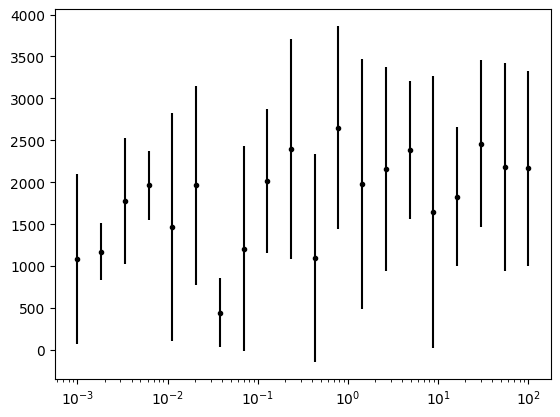

In [147]:
import matplotlib.pyplot as plt


plt.errorbar(params['C'], profits, yerr=stds, fmt='.k')
plt.xscale('log')
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [148]:
for i in range(7):
    profits, _ = my_cross_val_C(trains_x, trains_y, tests_x, params, 'C')
    best_c = params['C'][np.argmax(profits)]
    print(f'Best C: {best_c}')
    print(f'Best C profit: {np.max(profits)}')

Best C: 29.763514416313193
Best C profit: 2726.1774578939794
Best C: 4.832930238571752
Best C profit: 2460.8721101184183
Best C: 4.832930238571752
Best C profit: 3067.488500362625
Best C: 100.0
Best C profit: 2362.1509276408115
Best C: 0.0379269019073225
Best C profit: 2556.1968160019765
Best C: 8.858667904100823
Best C profit: 2731.0026727481586
Best C: 2.636650898730358
Best C profit: 2904.5523921126355


Закономерность не просматривается, почти каждый раз коэф разный. Очень похоже, что это из-за нашего сильного элемента рандома. Это же можно было понять внимательно посмотрев на то, какое большое std на графике

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ я считаю что полнота важнее, так как цена ошибки (позвонить не туда) всего 1 доллар, а доход от 0 до 20, то есть в среднем 10 долларов. Итого, лучше звонить чаще но больше промахиваться (если не думать о том, что если не позвонить не туда будут проблемы в виде рассерженного клиента).



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [149]:
def my_cross_val_t(trains_x, trains_y, tests_x):
    profits = []
    stds = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for t in grid:
            incomes = []
            paids = []
            y_preds = []
            for X_train, y_train, X_test in zip(trains_x, trains_y, tests_x):
                model = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('classifier', LogisticRegression())])
                model.fit(X_train, y_train)
                y_proba = model.predict_proba(X_test)[:, 1]
                y_pred = np.zeros((X_test.shape[0], ))
                y_pred[y_proba >= t] = 1
                y_preds.append(y_pred)

            for y_pred, y_true in zip(y_preds, tests_y):
                paids.append(y_pred[y_pred == 1].shape[0])
                incomes.append(y_pred[(y_pred == 1) & (y_true == 1)].shape[0] * np.random.uniform(0, 20))

            incomes = np.array(incomes)
            paids = np.array(paids)
            mean_profit = (incomes - paids).mean()
            std =  (incomes - paids).std()
            profits.append(mean_profit)
            stds.append(std)

    return profits, stds

In [150]:
grid = np.arange(0, 1.01, step=0.01)
profits, stds = my_cross_val_t(trains_x, trains_y, tests_x)

In [151]:
best_t = grid[np.argmax(profits)]
print(f'Best t: {best_t}')
print(f'Best C profit: {np.max(profits)}')

Best t: 0.12
Best C profit: 6880.6367310677615


Гипотеза подтвердилась

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

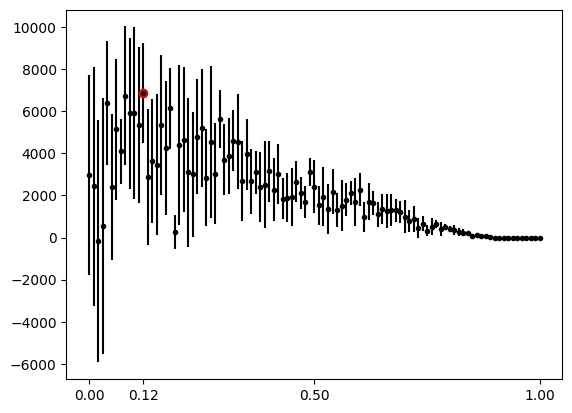

In [152]:
plt.errorbar(grid, profits, yerr=stds, fmt='.k')
plt.plot(grid[np.argmax(profits)], np.max(profits), 'ro')
plt.xticks([0, 1, 0.5, best_t])
plt.show()

In [153]:
for i in range(5):
    profits, stds = my_cross_val_t(trains_x, trains_y, tests_x)
    best_t = grid[np.argmax(profits)]
    print(f'Best t: {best_t}')
    print(f'Best C profit: {np.max(profits)}')

Best t: 0.08
Best C profit: 6893.675349254959
Best t: 0.08
Best C profit: 6938.073642080347
Best t: 0.08
Best C profit: 6504.176486452481
Best t: 0.1
Best C profit: 6354.394725120432
Best t: 0.06
Best C profit: 6329.428314082006


Порог всегда достаточно маленький. Это значит, что для нашей задачи модель считает важность recall выше важности precision.

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [154]:
from sklearn.metrics import recall_score, precision_score


with warnings.catch_warnings():
    y_preds = []
    warnings.simplefilter("ignore")
    for X_train, y_train, X_test in zip(trains_x, trains_y, tests_x):
        model = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', LogisticRegression())])
        model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = np.zeros((X_test.shape[0], ))
        y_pred[y_proba >= best_t] = 1
        y_preds.append(y_pred)


    precisions = []
    recalls = []
    for y_pred, y_true in zip(y_preds, tests_y):
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)

        precisions.append(precision)
        recalls.append(recall)

    print(f'Avg recall: {np.array(recalls).mean()}')
    print(f'Avg precision: {np.array(precisions).mean()}')
    print(f'Std recall: {np.array(recalls).std()}')
    print(f'Std precision: {np.array(precisions).std()}')

Avg recall: 0.796404978309045
Avg precision: 0.19425576809210215
Std recall: 0.009786529837176943
Std precision: 0.005398874143116525


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [155]:
high_recall_t = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for t in grid:
        y_preds = []
        for X_train, y_train, X_test in zip(trains_x, trains_y, tests_x):
            model = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', LogisticRegression())])
            model.fit(X_train, y_train)

            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = np.zeros((X_test.shape[0], ))
            y_pred[y_proba >= t] = 1
            y_preds.append(y_pred)


        recalls = []
        precisions = []
        for y_pred, y_true in zip(y_preds, tests_y):
            recall = recall_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            recalls.append(recall)
            precisions.append(precision)

        mean_recall = np.array(recalls).mean()

        if mean_recall >= 0.5:
            high_recall_t.append(t)
        else:
            break

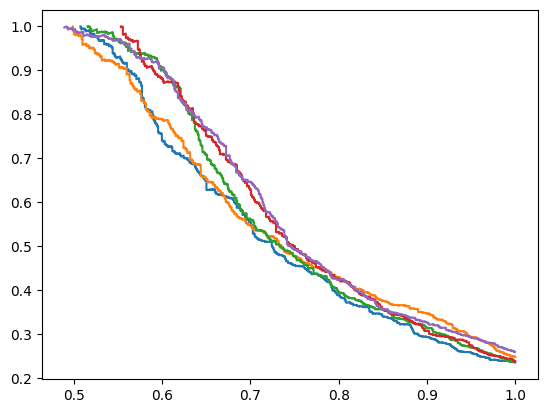

Mean prc-auc in high recall zone: 0.2656122987361366


In [156]:
y_preds = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for X_train, y_train, X_test in zip(trains_x, trains_y, tests_x):
        model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        y_preds.append(y_proba)

    prc_aucs = []
    for y_pred, y_true in zip(y_preds, tests_y):
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        precision_t = precision[:-1][thresholds <= np.max(high_recall_t)] # Выбираем только те пороги, что нам подходят

        # Среди них считаем precision и recall и нормируем их чтобы максимум стал = 1
        recall_t = recall[:-1][thresholds <= np.max(high_recall_t)]
        plt.plot(recall_t / np.max(recall_t ), precision_t / np.max(precision_t ))
        prc_aucs.append(auc(recall_t/ np.max(recall_t ), precision_t/ np.max(precision_t )))
    plt.show()

print('Mean prc-auc in high recall zone:', np.array(prc_aucs).mean())

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Я ел кашку быстров, потому что мой любимый чанжан-мён закончился (